# Статистические модели прогнозирования. Практика

Задача - проанализировать ВВП африканской страны Гана.

Прочитаем исходный файл с данными:

In [267]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/SkillFactory/ghana_gdp.csv', parse_dates=['year'], index_col=['year'])
data.info

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<bound method DataFrame.info of             GDP (current US$)
year                         
1960-01-01       1.217087e+09
1961-01-01       0.000000e+00
1962-01-01       1.382353e+09
1963-01-01       1.540616e+09
1964-01-01       1.731092e+09
...                       ...
2017-01-01       6.040638e+10
2018-01-01       6.729928e+10
2019-01-01       6.833754e+10
2020-01-01       7.004320e+10
2021-01-01       7.759428e+10

[62 rows x 1 columns]>

In [268]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Визуализируем исходный временной ряд:

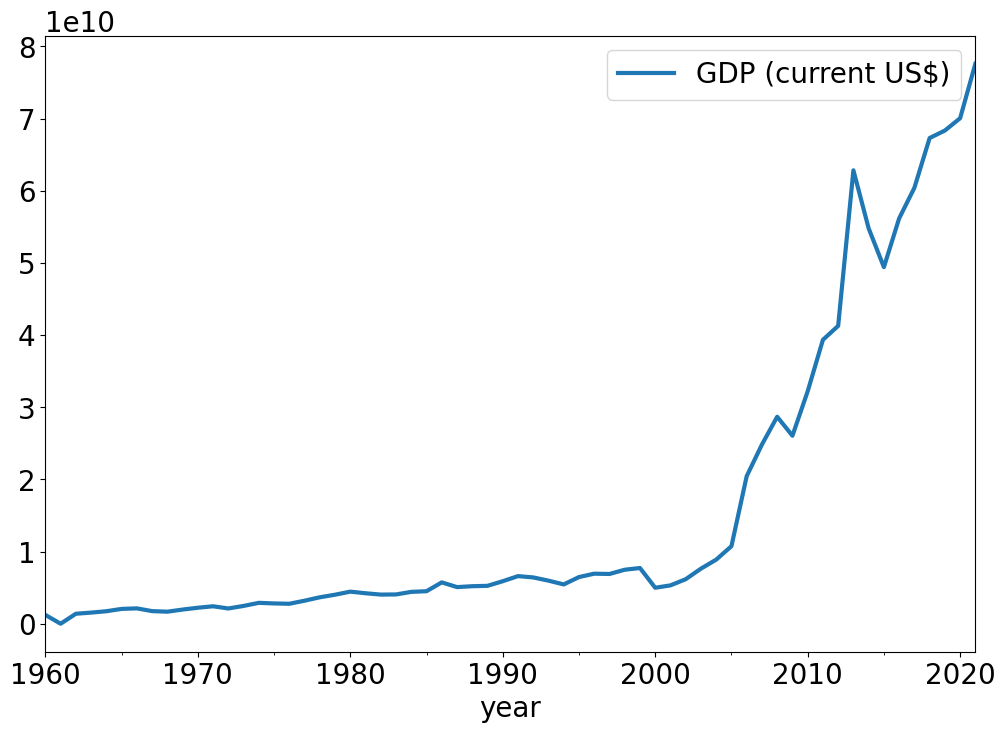

In [269]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [270]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Сделаем декомпозицию временного ряда:

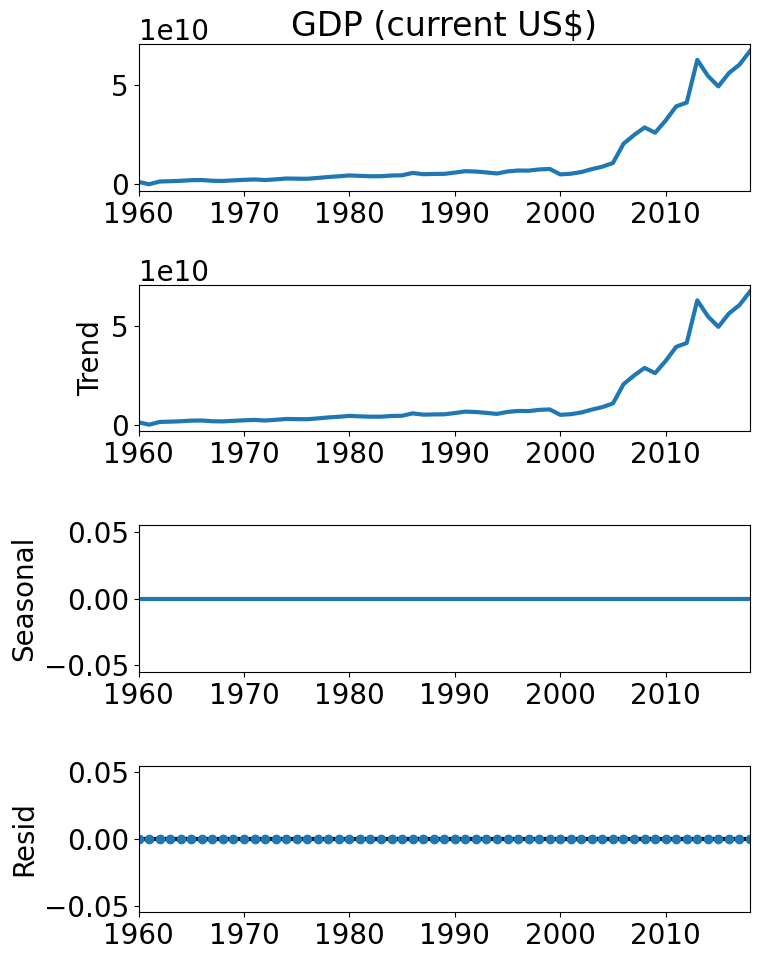

In [271]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 8, 10

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

Сезонная компонента и дисперсия равна нулю, график тренда повторяет график исходного ряда.

Визуализируем исходный временной ряд и построенный с помощью скользящего среднего:

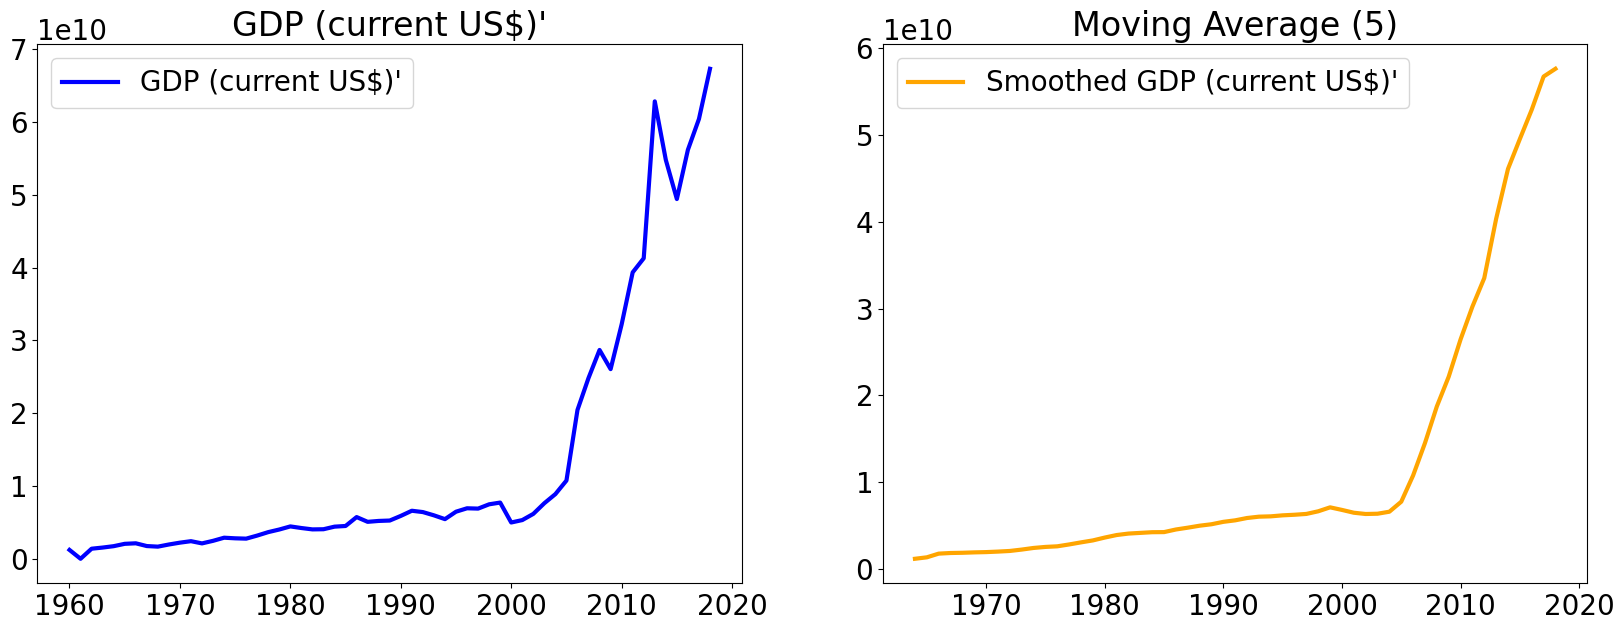

In [272]:
plt.rcParams["figure.figsize"] = 20, 7

fig, ax = plt.subplots(1, 2)


ax[0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)'")
ax[0].set_title("GDP (current US$)'", size=24)
ax[0].legend()

ax[1].plot(
    train_df['GDP (current US$)'].rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP (current US$)'",
)

ax[1].set_title("Moving Average (5)", size=24)
ax[1].legend()

plt.show()

Еще раз убеждаемся, что тренд положительный с увеличением темпа роста после 2005 года. Графики рядов, построенные с помощью скользящего среднего похожи на график исходного ряда.

Автокорреляция:

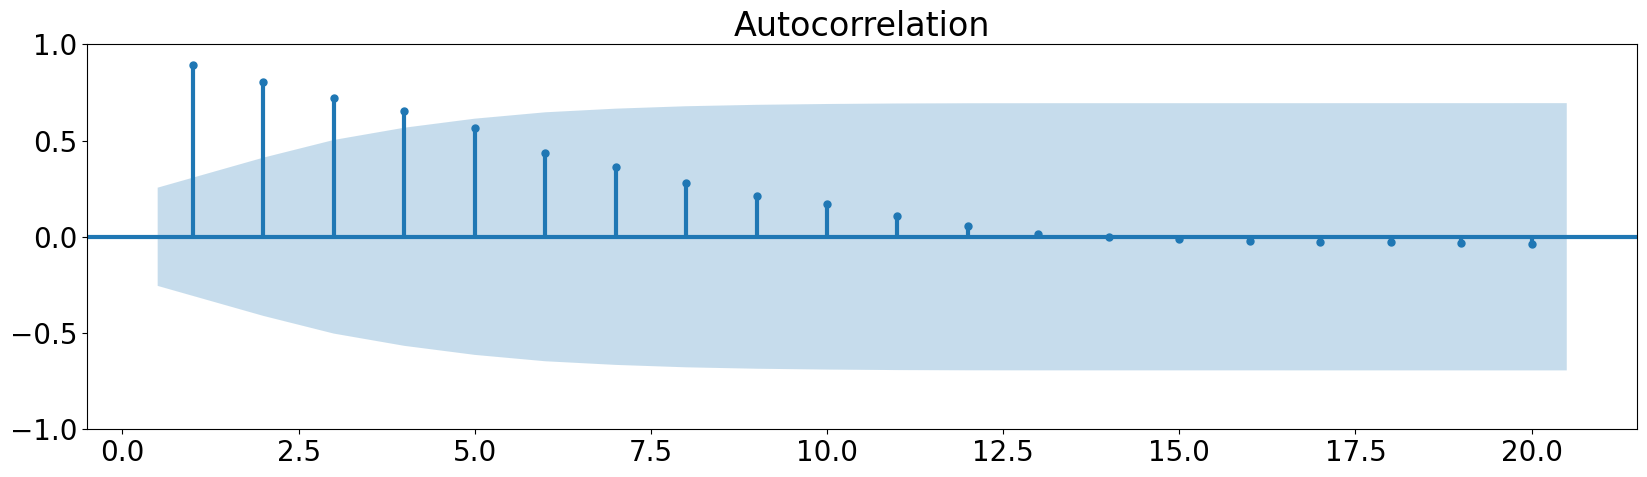

In [273]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['GDP (current US$)'], lags=20, zero=False)
plt.show()

Корреляция сохраняется до 12 лага.

Частичная автокорреляция:

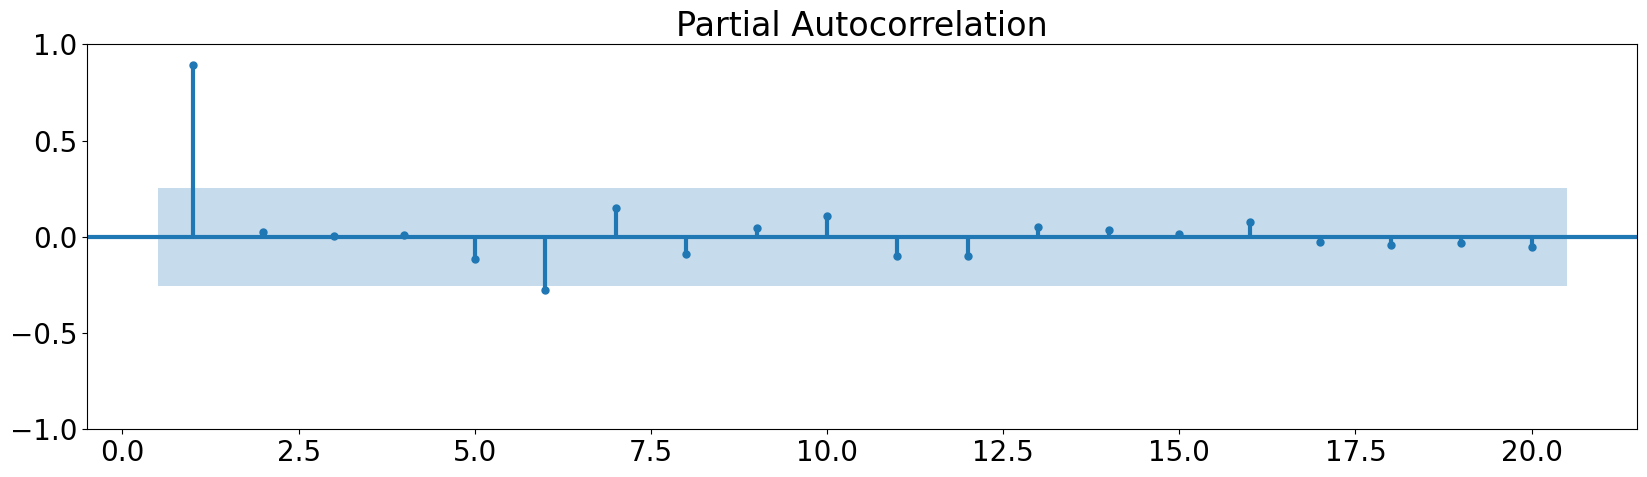

In [274]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['GDP (current US$)'], lags=20, method="ywm", zero=False)
plt.show()

В отличие от того, что предлагали графики ACF,  уровень GDP с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается = 1.

Проведем тест на стационарность:

In [275]:
from statsmodels.tsa.stattools import adfuller

def df_test(data):
    test_1 = adfuller(data)
    print("adf: ", test_1[0])
    print("p-value: ", test_1[1])
    print("Critical values: ", test_1[4])
    if test_1[0] > test_1[4]["5%"]:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

df_test(train_df['GDP (current US$)'])


adf:  0.6529066974885405
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where,
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

In [276]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=12)
    sgt.plot_pacf(series, ax=axes[1], lags=12, method="ywm")
    plt.show()

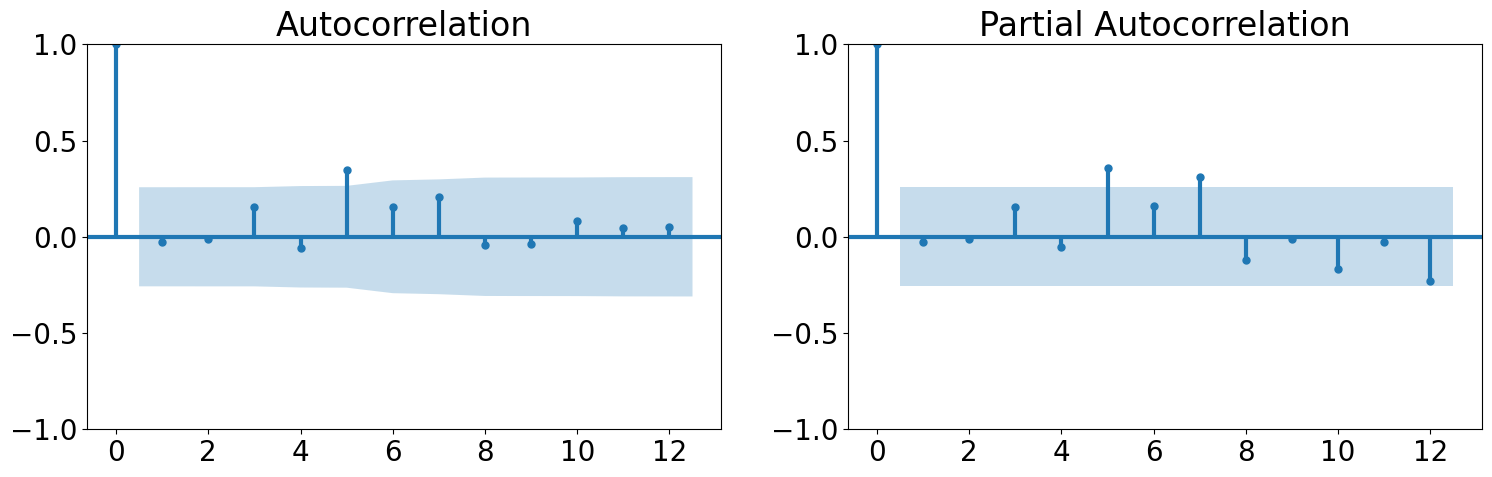

adf:  -1.670248303832082
p-value:  0.44650293297138693
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Ряд нестационарен


In [277]:
plot_acf_pacf(train_df['GDP (current US$)'].diff().dropna())

diff_1 = train_df['GDP (current US$)'].diff().dropna()

df_test(diff_1)

Принимаем p и q = 1.

Первые разности являются нестационарными

In [278]:
diff_2 = diff_1.diff().dropna()

df_test(diff_2)

adf:  -2.6408690561284924
p-value:  0.08484116917837625
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


Разности второго порядка являются нестационарными

In [279]:
diff_3 = diff_2.diff().dropna()

df_test(diff_3)

adf:  -4.779623784828569
p-value:  5.948327640223947e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд стационарен


Разности третьего порядка уже являются стационарными, принимем d = 3.

**PMDARIMA**

Начнем построение модели **PMDARIMA**:

In [280]:
pip install pmdarima

In [281]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=12,
    max_q=3,
    D=1,
    start_P=0,
    seasonal=False,
    # m=50,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.07 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.18 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.08 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.19 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.12 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.16 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 3.967 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Thu, 29 Jun 2023   AIC                           2659.231
Time:                        19:49:35   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Наилучшие параметры:
p = 2,
d = 3,
q = 1

**ARIMA**

Найденные ранее параметры:
- p = 1
- d = 3
- q = 1

In [282]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(1, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.455
Date:                Thu, 29 Jun 2023   AIC                           2670.910
Time:                        19:49:35   BIC                           2676.986
Sample:                    01-01-1960   HQIC                          2673.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5073      0.091     -5.600      0.000      -0.685      -0.330
ma.L1         -0.9751      0.132     -7.380      0.000      -1.234      -0.716
sigma2      4.066e+19   1.88e-21   2.17e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):               140.21
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             441.28   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.73e+55. Standard errors may be unstable.
"""

Автоматический поиск параметров показал лучший результат.

Построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза:

In [283]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = smodel.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']

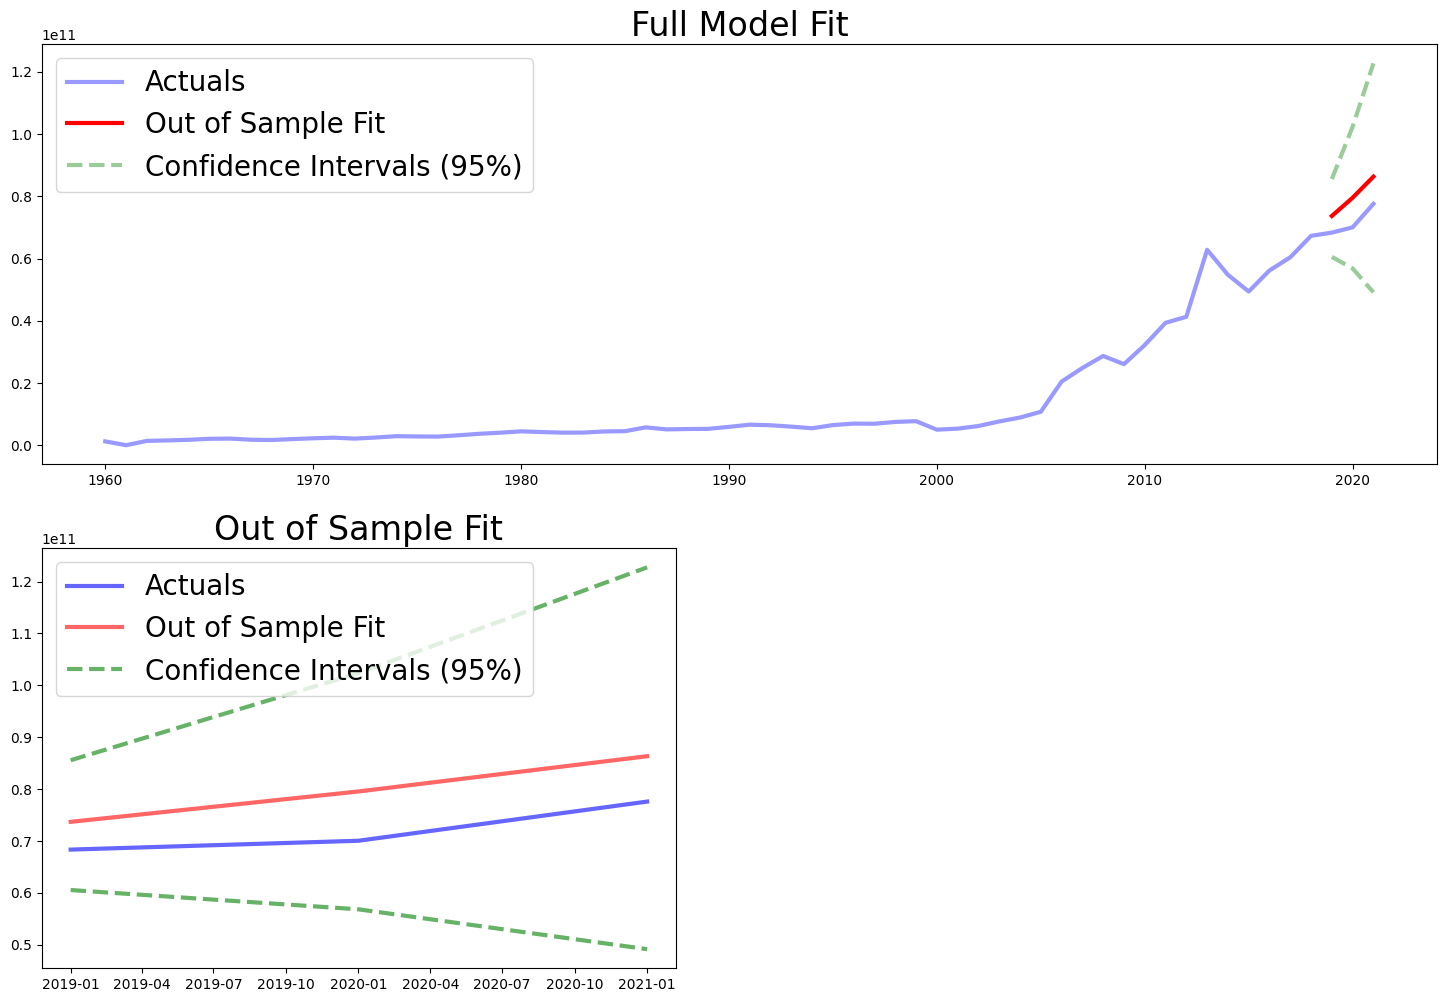

In [284]:
plt.rcParams["figure.figsize"] = 18, 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()



plt.show()

Предсказанный уровень GDP визуально продлевает предыдущую линию роста.

## Downsampling / Upsampling / Интерполяция

Проверим данные на наличие пропущенных дат:

In [285]:
data = data.asfreq(freq='YS')

Проверим данные на наличие пропущенных значений:

In [286]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

Сделаем проверку на наличие нулевых значений и в случае нахождения заменим их на NaN.

In [287]:
import numpy as np

data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)


Выполним интерполяцию с использованием метода .interpolate():

In [288]:
int_data = data['GDP (current US$)'].interpolate(method='linear')

Визуализируем полученный временной ряд:

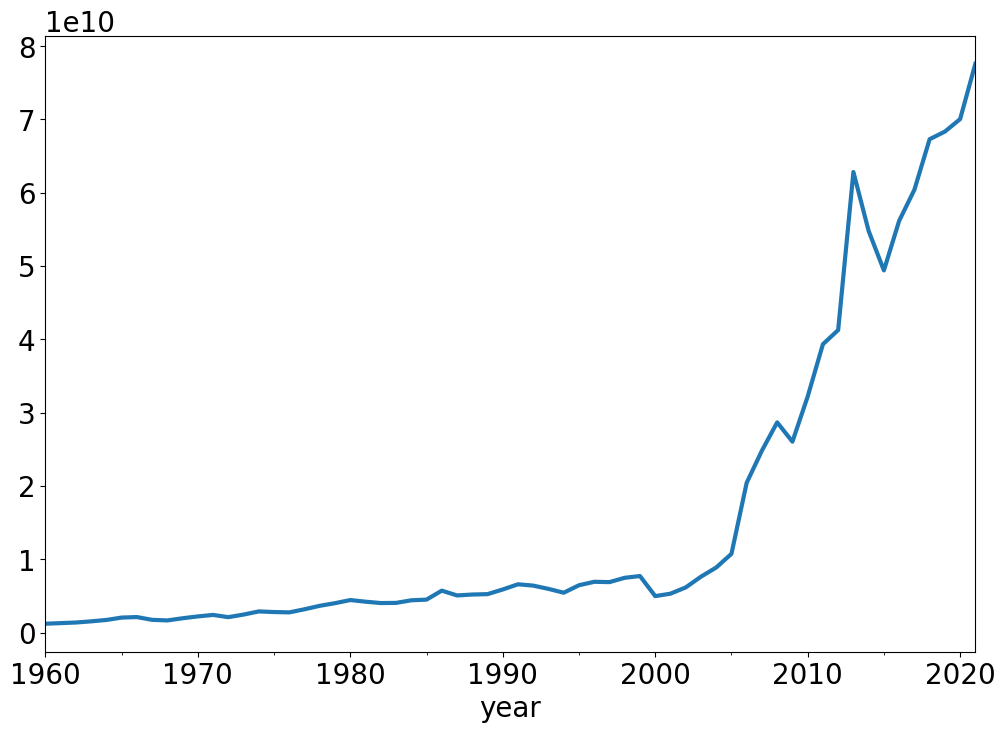

In [289]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3

int_data.plot()
plt.show()

Проверим полученный ряд на стационарность:

In [290]:
df_test(int_data)

adf:  2.3808487575556314
p-value:  0.99900101016983
Critical values:  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
Ряд нестационарен


In [291]:
diff_1 = int_data.diff().dropna()
df_test(diff_1)

adf:  -1.739718489292154
p-value:  0.41077316906677397
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


In [292]:
diff_2 = diff_1.diff().dropna()
df_test(diff_2)

adf:  -1.7042548913504167
p-value:  0.42892157301176387
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


In [293]:
diff_3 = diff_2.diff().dropna()
df_test(diff_3)

adf:  -5.456208629828514
p-value:  2.578324497203478e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд стационарен


Для получения стационарного ряда потребовалось диффиринцирование до 3-го порядка. Принимаем d = 3.

Построим графики автокорреляции и частичной корреляции:

In [294]:
train_df = int_data.iloc[:-3]
test_df = int_data.iloc[-3:]
train_df.shape, test_df.shape

((59,), (3,))

Графики обучающего ряда:

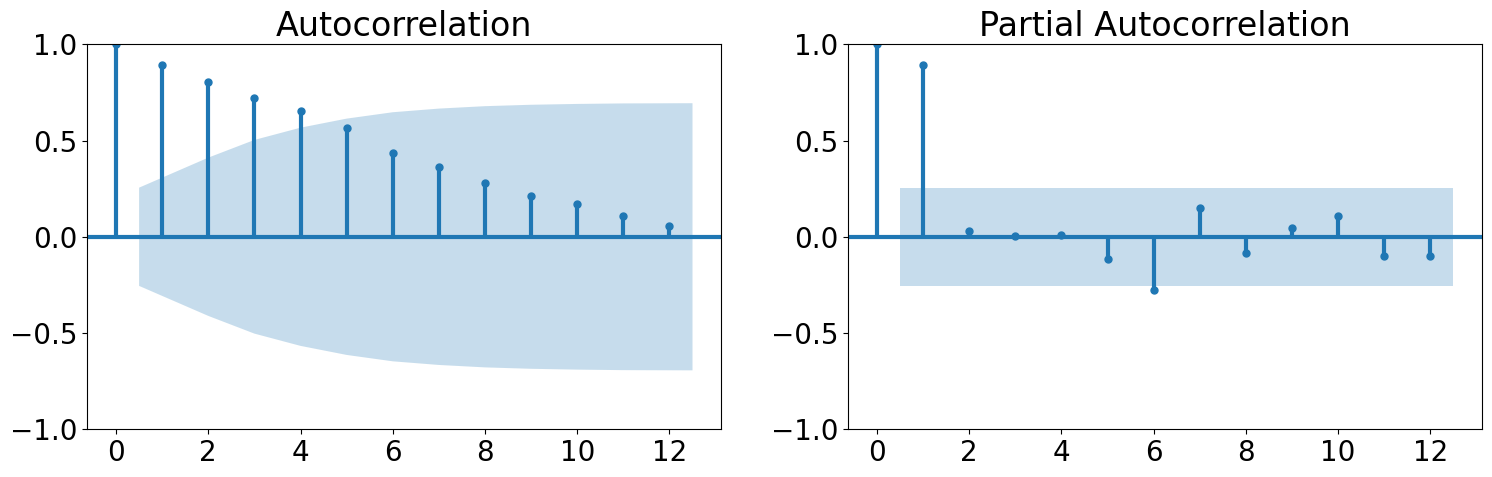

In [295]:
plot_acf_pacf(train_df)

Построим графики обучающего ряда после диффиренцирования:

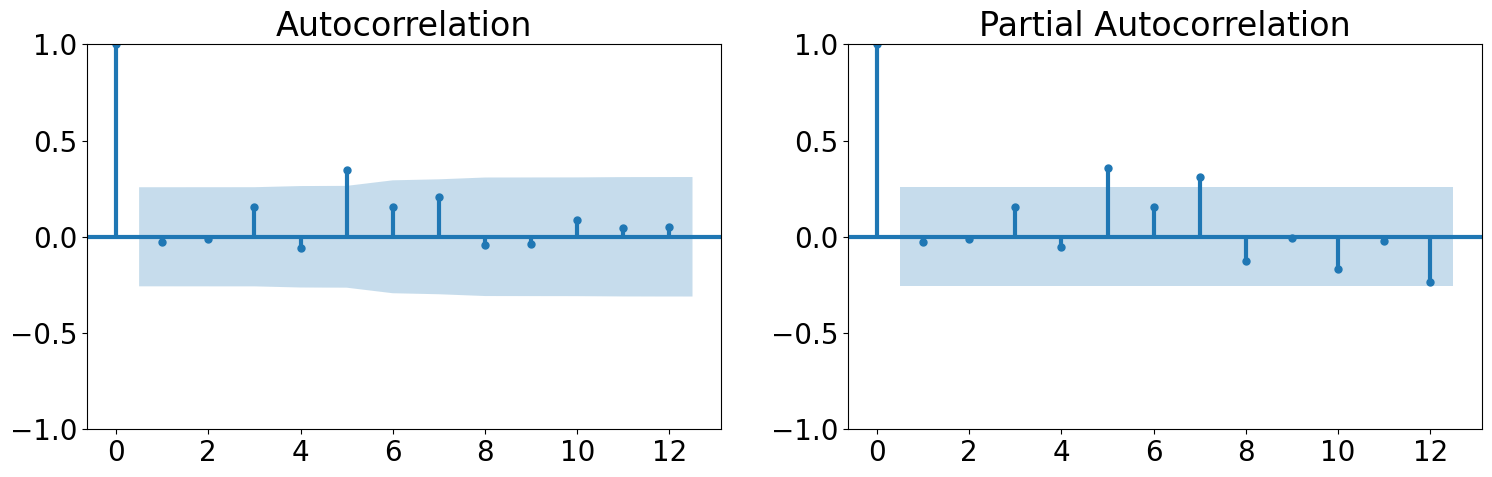

In [296]:
plot_acf_pacf(train_df.diff().dropna())

На дифферинцированных данных автокорреляция и частичная автокорреляция резко падает уже на 1-м лаге. Принимаем p = 1, q = 1.

**ARIMA**

In [297]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df.dropna(), order=(1, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.466
Date:                Thu, 29 Jun 2023   AIC                           2670.933
Time:                        19:49:39   BIC                           2677.009
Sample:                    01-01-1960   HQIC                          2673.289
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5077      0.091     -5.602      0.000      -0.685      -0.330
ma.L1         -0.9750      0.132     -7.378      0.000      -1.234      -0.716
sigma2      4.072e+19   1.87e-21   2.18e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.35   Jarque-Bera (JB):               140.71
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             539.85   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.73e+55. Standard errors may be unstable.
"""

Попробуем подобрать лучшие параметры при помощи PMDARIMA:

In [298]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=12,
    max_q=3,
    D=1,
    start_P=0,
    seasonal=False,
    # m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.06 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.11 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.12 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.08 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.325 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Thu, 29 Jun 2023   AIC                           2659.226
Time:                        19:49:40   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.29e+56. Standard errors may be unstable.
"""

Автоматический поиск параметров показал лучший результат.

Построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза:

In [299]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = smodel.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']

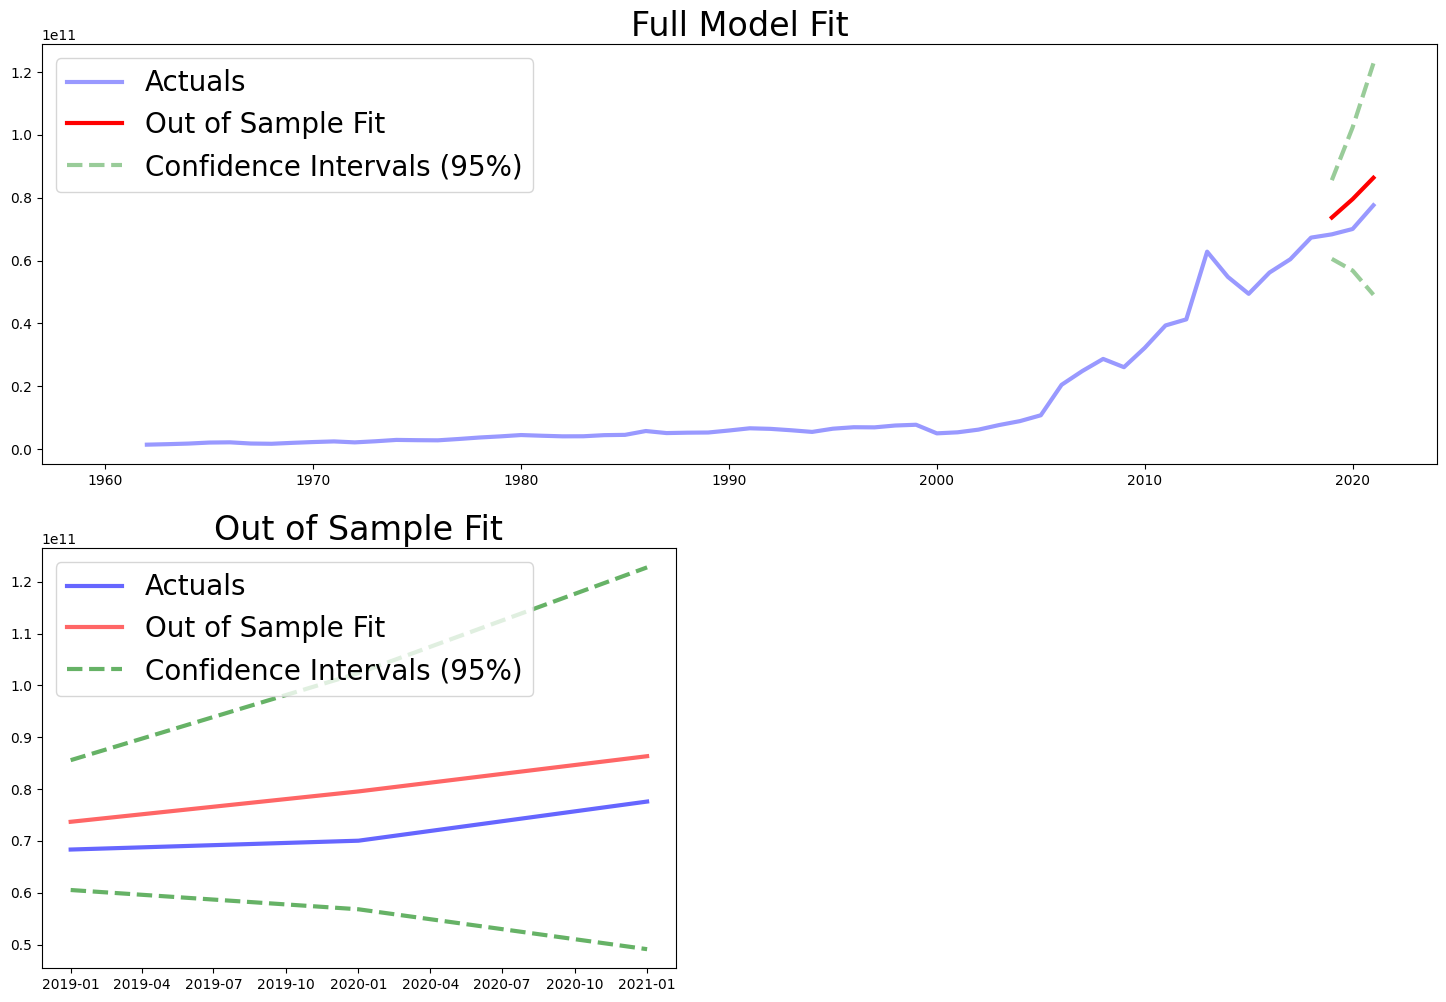

In [300]:
plt.rcParams["figure.figsize"] = 18, 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()



plt.show()

Предсказание на интеполированных данных показало такой же результат, есть незначительное снижение AIC.